# Part 1

## 1. Read in the rating file and create an RDD consisting of parsed lines, then count the number of ratings.

In [1]:
from pyspark import SparkContext

sc = SparkContext()
ratings_rdd = sc.textFile("./dataset/ratings.csv")

# 关闭 SparkContext
sc.stop()

header = ratings_rdd.first()

# 去除头部，然后解析每一行
ratings_rdd = ratings_rdd.filter(lambda line: line != header) \
    .map(lambda line: line.split(',')) \
    .map(lambda tokens: (tokens[0], tokens[1], float(tokens[2]), tokens[3]))

num_ratings = ratings_rdd.count()

num_ratings

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/18 11:53:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/18 11:53:27 ERROR Utils: Exception encountered
java.lang.NullPointerException
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$2(TorrentBroadcast.scala:255)
	at org.apache.spark.util.KeyLock.withLock(KeyLock.scala:64)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$1(TorrentBroadcast.scala:252)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:35)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException$(SparkErrorUtils.scala:33)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:94)
	at org.apache.spark.broadcast.TorrentBroadcast.readBroadcastBlock(TorrentBroadcast.scala:252)
	at org.apache.spark.broadcast.Torrent

Py4JJavaError: An error occurred while calling o21.partitions.
: java.io.IOException: java.lang.NullPointerException
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:42)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException$(SparkErrorUtils.scala:33)
	at org.apache.spark.util.Utils$.tryOrIOException(Utils.scala:94)
	at org.apache.spark.broadcast.TorrentBroadcast.readBroadcastBlock(TorrentBroadcast.scala:252)
	at org.apache.spark.broadcast.TorrentBroadcast.getValue(TorrentBroadcast.scala:109)
	at org.apache.spark.broadcast.Broadcast.value(Broadcast.scala:70)
	at org.apache.spark.rdd.HadoopRDD.getJobConf(HadoopRDD.scala:146)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:204)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:291)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:291)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:287)
	at org.apache.spark.api.java.JavaRDDLike.partitions(JavaRDDLike.scala:61)
	at org.apache.spark.api.java.JavaRDDLike.partitions$(JavaRDDLike.scala:61)
	at org.apache.spark.api.java.AbstractJavaRDDLike.partitions(JavaRDDLike.scala:45)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.NullPointerException
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$2(TorrentBroadcast.scala:255)
	at org.apache.spark.util.KeyLock.withLock(KeyLock.scala:64)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$readBroadcastBlock$1(TorrentBroadcast.scala:252)
	at org.apache.spark.util.SparkErrorUtils.tryOrIOException(SparkErrorUtils.scala:35)
	... 29 more


## 2. Recommend 5 movies with the highest average rating.

In [11]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MovieLens").getOrCreate()
ratings_df = spark.createDataFrame(ratings_rdd, ["userId", "movieId", "rating", "timestamp"])

# 计算每部电影的平均评分
avg_ratings_df = ratings_df.groupBy("movieId").avg("rating")

# 降序排列并选出前5部
top_movies = avg_ratings_df.orderBy("avg(rating)", ascending=False).limit(5)

top_movies.show()

+-------+-----------+
|movieId|avg(rating)|
+-------+-----------+
| 159048|        5.0|
| 195641|        5.0|
| 169820|        5.0|
| 169338|        5.0|
| 182345|        5.0|
+-------+-----------+



## 4. Try to create visualizations to convey the insights.

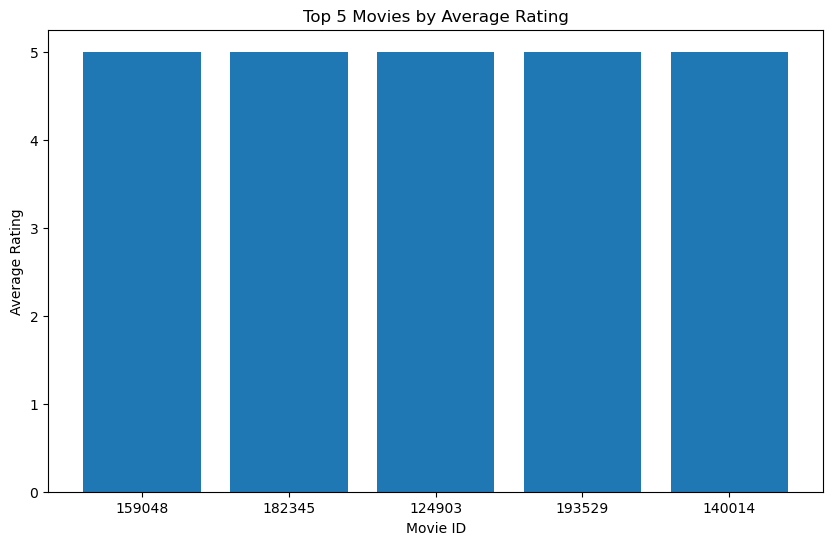

In [12]:
import matplotlib.pyplot as plt

# 以Pandas DataFrame的形式获取数据
top_movies_pd = top_movies.toPandas()

# 创建可视化
plt.figure(figsize=(10, 6))
plt.bar(top_movies_pd['movieId'], top_movies_pd['avg(rating)'])
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.title('Top 5 Movies by Average Rating')
plt.show()

# Part2

## 6. Divide training set and test set

In [ ]:
# 首先，转换成适合机器学习的格式
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

ratings_ml = ratings_df.rdd.map(lambda r: Row(userId=int(r[0]), movieId=int(r[1]), rating=float(r[2])))
ratings_ml_df = spark.createDataFrame(ratings_ml)

# 划分数据集
(training, test) = ratings_ml_df.randomSplit([0.7, 0.3])